# MC dropout Exploration

Produce N forward passes and record variance and mean.

Train model that receives variance and mean of a particular diagnostic on a particular visit and models if that prediction should be positive or negative

In [1]:
from torch import nn
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence, pack_sequence

In [2]:
import os
cwd = os.getcwd()

# protection against running this cell multiple times
assert os.path.dirname(os.path.dirname(cwd)).split('/')[-1] == 'master-thesis','Oops, directory already changed previously as indended. Ignoring...'

# change working directory (if assert passed)
new_cwd = os.path.dirname(os.path.dirname(cwd)) # parent directory
os.chdir(new_cwd)

In [12]:
import sys
import os
this_dir = ".."
if this_dir not in sys.path:
    sys.path.append(this_dir)

from rnn_utils import DiagnosesDataset, split_dataset, MYCOLLATE
from rnn_utils import train_one_epoch, eval_model, outs2df_mc, compute_metrics, get_prediction_thresholds

from mourga_variational.variational_rnn import VariationalRNN

import torch
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import ParameterGrid, ParameterSampler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
idx = pd.IndexSlice

from config import Settings; settings = Settings()

import wandb

In [4]:
# Reproducibility
seed = settings.random_seed

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [5]:
dataset_id = 'diag_only'
grouping = 'ccs'
batch_size=64

In [6]:
dataset_folder = os.path.join(settings.data_base,settings.model_ready_dataset_folder,dataset_id)
print('dataset at',dataset_folder)

dataset = DiagnosesDataset(os.path.join(dataset_folder,'dataset.json'),grouping)

train_dataset = DiagnosesDataset(os.path.join(dataset_folder,'train_subset.json'),grouping)
val_dataset = DiagnosesDataset(os.path.join(dataset_folder,'val_subset.json'),grouping)
test_dataset = DiagnosesDataset(os.path.join(dataset_folder,'test_subset.json'),grouping)


len(train_dataset)
len(val_dataset)
len(test_dataset)


train_dataloader = DataLoader(train_dataset,batch_size=batch_size,collate_fn=MYCOLLATE(dataset),shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,collate_fn=MYCOLLATE(dataset)) #batch_size here is arbitrary and doesn't affect total validation speed
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,collate_fn=MYCOLLATE(dataset))

dataset at data/model_ready_dataset/diag_only


5249

1125

1125

In [7]:
input_size = next(iter(train_dataloader))['target_sequences']['sequence'].shape[2]
hidden_size = 100
num_layers = 1
n_labels = input_size
model_type = 'gru'

In [8]:
dropout = 0.2
dropouti = dropout
dropoutw = dropout
dropouto = dropout

In [9]:
model = VariationalRNN(input_size=input_size,
                       hidden_size=hidden_size,
                       n_labels=n_labels,
                       num_layers=num_layers,
                       rnn_type=model_type,
                       dropouti=dropouti,
                       dropoutw=dropoutw,
                       dropouto=dropouto
                      )

In [10]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss(reduction='none')
epochs = 10

In [13]:
losses = []
for epoch in range(epochs):
    loss = train_one_epoch(model,train_dataloader,epoch,criterion,opt)
    losses.append(loss)
    print(f'epoch: {epoch+1} | loss: {loss}')

epoch: 1 | loss: 0.17655376255153174
epoch: 2 | loss: 0.1268251751919827
epoch: 3 | loss: 0.12036091798400304
epoch: 4 | loss: 0.116629880684686
epoch: 5 | loss: 0.11437759386846819
epoch: 6 | loss: 0.11200085955570979
epoch: 7 | loss: 0.11009886160672429
epoch: 8 | loss: 0.10840898438031416
epoch: 9 | loss: 0.10687763935112092
epoch: 10 | loss: 0.10657619173268237


In [14]:
res,golden = outs2df_mc(model,val_dataloader,dataset,return_golden=True)
res.head(3)

diag_0    diag_1    diag_2    diag_3    diag_4  \
pat_id adm_index n_pass                                                     
21     1         1       0.005143  0.236630  0.152116  0.049454  0.002378   
                 2       0.006266  0.278250  0.166433  0.137691  0.024587   
                 3       0.001735  0.085257  0.044795  0.034010  0.002323   

                           diag_5    diag_6    diag_7    diag_8    diag_9  \
pat_id adm_index n_pass                                                     
21     1         1       0.003555  0.001772  0.002145  0.000576  0.007825   
                 2       0.004805  0.005583  0.036266  0.004576  0.003707   
                 3       0.005651  0.001131  0.000727  0.001374  0.010211   

                         ...  diag_262  diag_263  diag_264  diag_265  \
pat_id adm_index n_pass  ...                                           
21     1         1       ...  0.000153  0.003850  0.000752  0.023192   
                 2       ...  0.000122  0.002030  0.001379  0.010199   
                 3       ...  0.000080  0.001339  0.000225  0.001826   

                         diag_266  diag_267  diag_268  diag_269  diag_270  \
pat_id adm_index n_pass                                                     
21     1         1       0.159354  0.181789  0.007838  0.001354  0.003016   
                 2       0.355834  0.099752  0.014515  0.001962  0.003965   
                 3       0.145662  0.204045  0.000780  0.000676  0.000602   

                         diag_271  
pat_id adm_index n_pass            
21     1         1       0.035041  
                 2       0.033877  
                 3       0.032550  

[3 rows x 272 columns]

In [15]:
stats_res = res.groupby(['pat_id','adm_index']).agg(['mean','var'])
stats_res.head(3)

diag_0              diag_1              diag_2            \
                      mean       var      mean       var      mean       var   
pat_id adm_index                                                               
21     1          0.004604  0.000019  0.274418  0.010998  0.130371  0.001943   
23     1          0.003312  0.000008  0.154725  0.007403  0.112967  0.004035   
61     1          0.003840  0.000026  0.259053  0.016134  0.070913  0.000923   

                    diag_3              diag_4            ...  diag_267  \
                      mean       var      mean       var  ...      mean   
pat_id adm_index                                          ...             
21     1          0.079600  0.001907  0.007998  0.000188  ...  0.138223   
23     1          0.052768  0.001460  0.007994  0.000200  ...  0.070436   
61     1          0.094566  0.004621  0.013870  0.000428  ...  0.200941   

                            diag_268            diag_269                \
                       var      mean       var      mean           var   
pat_id adm_index                                                         
21     1          0.003573  0.005350  0.000019  0.001989  1.367239e-06   
23     1          0.001024  0.004464  0.000032  0.002788  6.539050e-06   
61     1          0.013335  0.002412  0.000002  0.001263  2.926037e-07   

                  diag_270            diag_271            
                      mean       var      mean       var  
pat_id adm_index                                          
21     1          0.001894  0.000002  0.044724  0.000453  
23     1          0.012294  0.000186  0.029343  0.000175  
61     1          0.004148  0.000008  0.046663  0.000384  

[3 rows x 544 columns]

In [18]:
P = golden == 1
F = ~P

variances = stats_res.loc[idx[:,:],idx[:,'var']]
variances.columns = variances.columns.get_level_values(0)
#variances.head(3)

means = stats_res.loc[idx[:,:],idx[:,'mean']]
means.columns = means.columns.get_level_values(0)
#means.head(3)

P_variances = variances.where(P,np.nan)
F_variances = variances.where(F,np.nan)

P_means = means.where(P,np.nan)
F_means = means.where(F,np.nan)

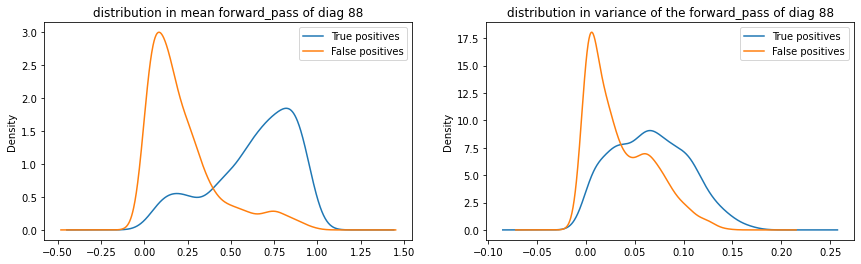

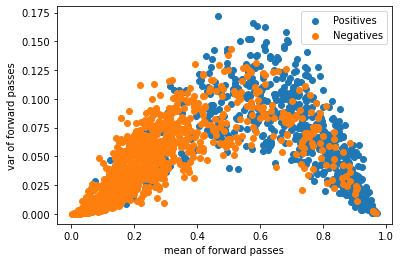

In [20]:
#parameter
diag = 88


diag_col = f'diag_{diag}'
plt.subplot(1,2,1);
P_means[diag_col].plot.kde(label='True positives');
F_means[diag_col].plot.kde(label='False positives');
plt.title(f'distribution in mean forward_pass of diag {diag}');
plt.legend();
#plt.show();
plt.subplots_adjust(right=2) 
plt.subplot(1,2,2)
P_variances[diag_col].plot.kde(label='True positives');
F_variances[diag_col].plot.kde(label='False positives');
plt.title(f'distribution in variance of the forward_pass of diag {diag}');
plt.legend();
plt.show();

p = pd.concat([P_means[diag_col],P_variances[diag_col]],axis=1)
p.columns = ['mean','var']

f = pd.concat([F_means[diag_col],F_variances[diag_col]],axis=1)
f.columns = ['mean','var']

plt.scatter(p['mean'],p['var'],label='Positives');
plt.scatter(f['mean'],f['var'], label = 'Negatives');
plt.xlabel('mean of forward passes');
plt.ylabel('var of forward passes');
plt.legend();

# Model whether a prediction will be FP or TP

# Dumb classifier

since some diagnostics won't have enough data to train a model on, we will use 'dumb' classifiers to keep the pipeline consistent. These classifiers will always predict the positive class

In [21]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class DumbClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self):
        pass
    def fit(self, X, y):
        # Check that X and y have correct shape
        #X, y = check_X_y(X, y)
        # Store the classes seen during fit
        #self.classes_ = unique_labels(y)
        #self.X_ = X
        #self.y_ = y
        # Return the classifier
        return self

    def predict(self, X):
         # Check if fit has been called
        #check_is_fitted(self)
        
        # Input validation
        #X = check_array(X)
        y = np.zeros(shape=(X.shape[0],),dtype=int)
        return y

# test this out
from sklearn.pipeline import make_pipeline

X = np.ones(shape=(5,5))
y = np.random.randint(0,2,size=(5,))

pipe = make_pipeline(DumbClassifier())

pipe.fit(X,y)
pipe.predict(X) # Expecting all ones

Pipeline(steps=[('dumbclassifier', DumbClassifier())])

array([0, 0, 0, 0, 0])

# Build dataset

we shall build the dataset using the validation set (from the original train-val-test split).

We need:
1. obtain predictions on the validation set
2. gather all TP and FP examples
3. construct N tabular datasets (one for each diagnostic)
4. split each into train-test
5. train and test classifier
    1. metric should be precision, recall and f1

In [127]:
outs, golden = outs2df_mc(model,val_dataloader,dataset,return_golden=True)

In [128]:
stats_outs = outs.groupby(['pat_id','adm_index']).agg(['mean','var'])

P = golden == 1
F = ~P

variances = stats_outs.loc[idx[:,:],idx[:,'var']]
variances.columns = variances.columns.get_level_values(0)
#variances.head(3)

means = stats_outs.loc[idx[:,:],idx[:,'mean']]
means.columns = means.columns.get_level_values(0)
#means.head(3)

P_variances = variances.where(P,np.nan)
F_variances = variances.where(F,np.nan)

P_means = means.where(P,np.nan)
F_means = means.where(F,np.nan)

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,precision_score,f1_score
from sklearn.linear_model import LogisticRegression

In [130]:
# need two conditions to decide wether to use the dumb classifier or not
# 1) threhsold on the number of examples
# 2) and there must be examples of both classes

df_metrics = pd.DataFrame(columns=['diag','precision','recall','f1','clf','type'])

signal = False
clf_party = {}
threshold = 20
for diag in outs.columns:
    
    n_P = (P[diag] == True).sum()
    n_F = (F[diag] == True).sum()
    
    total_n = n_P + n_F
    
    if total_n < threshold or n_P < 5 or n_F < 5:
        #use dumb classifier
        clf = DumbClassifier()
        df_metrics = df_metrics.append({'diag':diag,'precision':np.nan,'recall':np.nan,'f1':np.nan,'clf':clf,'type':'dumb'},ignore_index=True)
    else:
        #use logistic regression
        
        ## create dataset
        mean_p = means[diag][P[diag]].to_frame('mean')
        mean_f = means[diag][F[diag]].to_frame('mean')
        
        var_p = variances[diag][P[diag]].to_frame('var')
        var_f = variances[diag][F[diag]].to_frame('var')
        
        df_p = pd.concat([mean_p,var_p],axis=1).assign(label=1).reset_index(drop=True)
        df_f = pd.concat([mean_f,var_f],axis=1).assign(label=0).reset_index(drop=True)
        
        df = pd.concat([df_p,df_f],ignore_index=True).sample(frac=1.0)
        
        if signal == False:
            print('TP/FP dataset for diagnostic ',diag)
            display(df)
            signal = True
        
        ## split into train-test
        
        X_train,X_test,y_train,y_test = train_test_split(df[['mean','var']],df['label'],stratify=df['label'])
        
        ## train
        clf = LogisticRegression(class_weight="balanced");
        clf.fit(X_train,y_train);
        
        ## evaluate
        preds = clf.predict(X_test);
        
        precision = precision_score(y_test,preds)
        recall = recall_score(y_test,preds)
        f1 = f1_score(y_test,preds)
        
        df_metrics = df_metrics.append({'diag':diag,'precision':precision,'recall':recall,'f1':f1,'clf':clf,'type':'model'},ignore_index=True)
    
    clf_party[diag] = clf
    

TP/FP dataset for diagnostic  diag_0


,mean,var,label
619,0.001141,2.081284e-06,0
562,0.002722,1.071653e-05,0
922,0.001749,1.436067e-05,0
678,0.004715,8.431326e-06,0
1393,0.000852,1.285400e-06,0
...,...,...,...
126,0.002280,1.091673e-05,0
1174,0.000760,3.792065e-07,0
1165,0.001574,5.553017e-06,0
219,0.000826,1.913729e-06,0


LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

In [131]:
df_metrics

,diag,precision,recall,f1,clf,type
0,diag_0,0.025000,0.500000,0.047619,LogisticRegression(class_weight='balanced'),model
1,diag_1,0.301136,0.552083,0.389706,LogisticRegression(class_weight='balanced'),model
2,diag_2,0.207071,0.611940,0.309434,LogisticRegression(class_weight='balanced'),model
3,diag_3,0.117188,0.625000,0.197368,LogisticRegression(class_weight='balanced'),model
4,diag_4,0.727273,1.000000,0.842105,LogisticRegression(class_weight='balanced'),model
...,...,...,...,...,...,...
267,diag_267,0.115152,0.422222,0.180952,LogisticRegression(class_weight='balanced'),model
268,diag_268,0.115385,0.500000,0.187500,LogisticRegression(class_weight='balanced'),model
269,diag_269,NaN,NaN,NaN,DumbClassifier(),dumb
270,diag_270,0.000000,0.000000,0.000000,LogisticRegression(class_weight='balanced'),model


In [132]:
df_metrics.f1.describe()

count    208.000000
mean       0.258926
std        0.225921
min        0.000000
25%        0.057629
50%        0.198684
75%        0.426877
max        0.888889
Name: f1, dtype: float64

In [136]:
try:
    df_metrics = df_metrics.set_index('diag')
except:
    pass
df_metrics.head(5)

,precision,recall,f1,clf,type
diag,,,,,
diag_0,0.025000,0.500000,0.047619,LogisticRegression(class_weight='balanced'),model
diag_1,0.301136,0.552083,0.389706,LogisticRegression(class_weight='balanced'),model
diag_2,0.207071,0.611940,0.309434,LogisticRegression(class_weight='balanced'),model
diag_3,0.117188,0.625000,0.197368,LogisticRegression(class_weight='balanced'),model
diag_4,0.727273,1.000000,0.842105,LogisticRegression(class_weight='balanced'),model


## Classifiers are trained. Now we need to apply them

In [137]:
# notice we use the test set now
outs, golden = outs2df_mc(model,test_dataloader,dataset,return_golden=True)

In [138]:
stats_outs = outs.groupby(['pat_id','adm_index']).agg(['mean','var'])
stats_outs.head(3)

diag_0              diag_1              diag_2            \
                      mean       var      mean       var      mean       var   
pat_id adm_index                                                               
111    1          0.001488  0.000001  0.101669  0.002011  0.058453  0.000577   
145    1          0.001981  0.000008  0.383406  0.024986  0.132077  0.002758   
199    1          0.001249  0.000002  0.199931  0.004378  0.114665  0.003338   

                    diag_3              diag_4            ...  diag_267  \
                      mean       var      mean       var  ...      mean   
pat_id adm_index                                          ...             
111    1          0.058916  0.000819  0.002301  0.000014  ...  0.076222   
145    1          0.058654  0.001048  0.023743  0.004734  ...  0.108282   
199    1          0.046796  0.000964  0.014769  0.001182  ...  0.122908   

                            diag_268            diag_269                \
                       var      mean       var      mean           var   
pat_id adm_index                                                         
111    1          0.001842  0.010824  0.000190  0.001831  7.993428e-06   
145    1          0.002082  0.001591  0.000004  0.000682  6.293822e-07   
199    1          0.003760  0.003133  0.000007  0.000971  2.524555e-07   

                  diag_270            diag_271            
                      mean       var      mean       var  
pat_id adm_index                                          
111    1          0.003844  0.000015  0.045371  0.000671  
145    1          0.003727  0.000010  0.027566  0.000265  
199    1          0.001104  0.000001  0.034591  0.000330  

[3 rows x 544 columns]

In [139]:
P = golden == 1
F = ~P

variances = stats_outs.loc[idx[:,:],idx[:,'var']]
variances.columns = variances.columns.get_level_values(0)
#variances.head(3)

means = stats_outs.loc[idx[:,:],idx[:,'mean']]
means.columns = means.columns.get_level_values(0)
#means.head(3)

P_variances = variances.where(P,np.nan)
F_variances = variances.where(F,np.nan)

P_means = means.where(P,np.nan)
F_means = means.where(F,np.nan)

In [140]:
def mc_prediction(stats_outs_col,df_metrics):
    """
    Receives a row which contains the mean and variance predictions of all diagnoses for a given admission.
    Also receives df_metrics, which contains the LRs trained on each diagnostic (that predicts if TP or FP)
    And stats_outs contains the means and variances of the forward passes.
    
    this function decides which outputs become a positive or negative prediction.
    """
    diag = stats_outs_col.columns.get_level_values(0)[0]
    
    datapoints = stats_outs_col.to_numpy()

    #fetch the classifier for this diagnostic
    clf = df_metrics.loc[diag,'clf']

    #save prediction
    clf.predict(datapoints)
    
    new_col = pd.Series(data=clf.predict(datapoints),
                        index=stats_outs_col.index, 
                        dtype=np.int64, 
                        name=diag)
        
    return new_col

and abstain from topk now

In [141]:
diagnoses = stats_outs.columns.get_level_values(0).unique()
mc_predictions = pd.concat([mc_prediction(stats_outs.loc[:,idx[diag,:]],df_metrics) for diag in diagnoses],axis=1)

# Statistics of #predictions per admission

In [144]:
mc_predictions.sum(axis=1).describe()

count    1878.000000
mean       43.582535
std        18.362924
min        10.000000
25%        29.000000
50%        41.000000
75%        55.000000
max       121.000000
dtype: float64

On average 43 diagnostic predictions per admission

In [145]:
# metrics of topk and abstention afterwards
logits = stats_outs.loc[:,idx[:,'mean']].droplevel(1,axis=1)
metrics_mc_prediction = compute_metrics(logits,mc_predictions,golden,['precision','recall','f1'])

In [146]:
metrics_mc_prediction.to_frame().iloc[3:]

,0
metrics,
recall_adm,0.614100
precision_adm,0.171355
f1_adm,0.258316


# Conclusions

Predicting if a proba is Positive or Negative doesn't really work all that well

-----

# Try a bunch of different configurations

Vary the model. Vary all the probabilities uniformly and vary each probability differently. Evaluate the abstention